# QMCF solver

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm, svd, pinv
from scipy import io
import networkx as nx

In [41]:
file = './MCF_1000.mat'
mat = io.loadmat(file)

In [42]:
E = mat['E']
b = mat['b'][0]
u = mat['u'][0]
q = mat['q'][0]
Q = mat['Q'][0]

In [4]:
E = np.array([[-1, -1, -1, 0, 0, 0], [1, 0, 0, -1, -1, 0], [0, 1, 0, 1, 0, -1], [0, 0, 1, 0, 1, 1]])
b = np.array([-10, 0, 0, 10])
u = np.array([10, 10, 10, 10, 10, 10])
q = np.array([4, 4, 4, 10, 2, 2])
Q = np.array([199, 100, 113, 105, 135, 145])

In [65]:
n = E.shape[1]
m = E.shape[0]

In [6]:
edges = []
# iterate by column
for i in range(n):
    # get node index of current edge
    node_index = E[:,i].nonzero()[0]
    # get direction of the current edge
    if E[node_index[0],i] < E[node_index[1],i]:
        edges.append((node_index[0], node_index[1]))
    else:
        edges.append((node_index[1], node_index[0]))

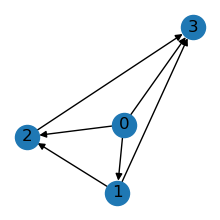

In [7]:
G = nx.empty_graph(0, nx.DiGraph)
G.add_nodes_from(range(E.shape[0]))
G.add_edges_from(edges)
plt.figure(figsize=(2,2)) 
nx.draw(G, with_labels=True)

## Solve initial problem

### Scipy

In [8]:
from scipy.optimize import Bounds, LinearConstraint, minimize

In [9]:
def f(x):
    return x.T @ np.diag(Q) @ x + q.T @ x

In [10]:
bounds = Bounds(np.zeros(n), u)
lin_const = LinearConstraint(E, b, b)

In [11]:
x0 = np.zeros(n)
res = minimize(f, x0, method='trust-constr',
               constraints=lin_const, bounds=bounds,
               options={'verbose': 1})

/opt/anaconda3/envs/cm/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


`xtol` termination condition is satisfied.
Number of iterations: 232, function evaluations: 1603, CG iterations: 304, optimality: 8.77e-05, constraint violation: 1.03e-16, execution time:  1.4 s.


In [12]:
print('x: '+str(res.x))
print('f(x): '+str(f(res.x)))
print('norm(Ex-b): '+str(norm(E@res.x-b)))

x: [1.87838282e+00 2.56073406e+00 5.56088312e+00 1.87584760e-07
 1.87838263e+00 2.56073425e+00]
f(x): 6328.2373522487715
norm(Ex-b): 1.0318010085992092e-16


### CVXPY

In [44]:
import cvxpy as cp

In [45]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, np.diag(Q)) + q.T @ x)
constraints = [0 <= x, x <= u, E@x==b]
prob = cp.Problem(objective, constraints)

In [46]:
res = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Nov 17 03:30:06 PM: Your problem has 1000 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 17 03:30:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 03:30:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 03:30:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 03:30:06 PM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 17 03:30:06 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

In [47]:
print('x: '+str(x.value))
print('f(x): '+str(res))
print('norm(Ex-b): '+str(norm(E@x.value-b)))

x: [ 1.08578896e+00  1.33499441e+00  1.41174876e+01  5.63497682e+00
  2.68776047e+00  5.79179349e+00  4.13167318e+00  1.49199766e+00
  1.37841566e+01  1.17260856e+01  9.79941753e+00  1.29350959e+01
  9.33878623e+00  1.65329081e+00  9.15395540e+00  3.18873987e+00
  3.90812774e+00  1.57136732e+00  5.66450447e+00  5.88683986e-21
  1.15499151e-01 -4.72075794e-21  3.25426043e-21  5.15126899e-02
  1.94075900e+00 -1.68945733e-22  1.31245188e-01  1.65883830e-21
  7.74601120e-01  4.84957900e-22 -1.58422269e-21  4.25984463e+00
 -3.11343571e-21  4.40265251e-22  9.32745329e-01  5.02072963e-22
 -1.88774370e-21  3.74787885e-01  3.89373919e-02  4.21092337e-01
  8.51862615e-02  7.16110316e-01  3.39788875e-02  1.33162016e-01
  1.57451271e+00  6.84981538e-01 -6.82027287e-20  2.21016264e-02
  3.02842864e-02  8.84905496e-02 -2.19842857e-21  2.93057999e-01
  1.25751664e+00  4.98854430e-01  4.68212049e-01 -2.81983703e-22
 -3.61508673e-21  8.00856812e-01  4.77428788e-02 -4.87856875e-22
  8.16984859e-02  2.99

## CompactSVD

In [17]:
def compactSVD(E):
    m = E.shape[0]
    r = m-1
    # Compute thin SVD
    U, s, Vt = svd(E, full_matrices=False)
    Um = U[:,-1]
    U = U[:, 0:r]
    S = np.diag(s[0:r])
    V = Vt.T[:,0:r]
    
    return U, S, V, Um   

In [18]:
U, S, V, Um = compactSVD(E)

In [19]:
np.allclose(E, U@S@V.T)

True

## getBoxedx

In [20]:
def getBoxedx(Q, q, E, b, u, mu):
    n = Q.shape[0]
    x = np.zeros(n)
    
    for i in range(n):
        if Q[i] == 0:
            if mu.T @ b < q[i]*u[i] + mu.T @ (E[:,i]*u(i) - b):
                x[i] = 0
            else:
                x[i] = u[i]
        else:
            x[i] = (-q[i] - E.T[i,:] @ mu)/(2*Q[i])
            x[i] = max(0, min(x[i], u[i]))
        
    return x

In [21]:
mu = np.zeros(m)

In [22]:
x = getBoxedx(Q, q, E, b, u, mu)

In [23]:
x

array([0., 0., 0., 0., 0., 0.])

## QMCF_solver

In [103]:
def QMCF_solver(Q, q, E, b, u, eps, l, lambd, best_l, m_lbm, max_iter):
    exitFlag=1
    n = E.shape[1]
    m = E.shape[0]
    U, S, V, Um = compactSVD(E)


    # Check satisfiability condition for E*x=b
    if np.abs(Um.T @ b) > 1.0e-10:
        print('Ex=b unsatisfiable')
        exitFlag = -1
        return [], exitFlag


    # Initilization of functions
    def f(x):
        return x.T @ np.diag(Q) @ x + q.T @ x

    def L(x, mu):
        return f(x) + mu.T @ (E@x - b)

    def dualf(x, mu):
        return -L(x, mu)
    
    # Primal and dual variables initialization
    bar_mu = np.zeros(m)
    bar_x = getBoxedx(Q, q, E, b, u, bar_mu)
    x_best = []

    x_lin_const = V @ pinv(S) @ U.T @ b
    
    # Bundle initialization
    z = b - (E@bar_x)
    alpha = np.dot(z, bar_mu) - dualf(bar_x, bar_mu)
    B_z = z
    B_alpha = alpha
    X = bar_x

    # Initialization of lower bound and upper bound
    LB = 0
    UB = np.Inf
    #LB = L(bar_x, bar_mu)
    #UB = f(bar_x)


    # Initialization of flags
    x_sat_const_found = False
    num_iterations = 0
    theta_case = 0
    d = 0

    #print('iter\tgap||theta|| ||bar_mu|| ||bar_x|| l Case ||New z|| New alpha ||d|| step')
    print('iter\tgap\t||theta||\t||bar_mu||\t||bar_x||\tl\tCase\t||New z||\tNew alpha\t||d||\tstep')
    while(np.abs(UB-LB) >= eps and num_iterations < max_iter):
    
        #[bar_mu, theta, l, d, steptype] = LBM(dualf, bar_x, bar_mu, l, B_z, B_alpha, lambda, best_l, m_lbm);
        theta = np.array([0])
        steptype = 'NS'
        d = 0

        # Case 1: theta is a convex combinator, optimal x
        if(np.abs(np.sum(theta)-1) <= eps and np.all((B_z.T @ theta)<eps)):
            theta_case = 1
            bar_x = X.T @ theta
            x_sat_const_found = True

        # Case 2: try to force x in [0,u] using a Lagrangian heuristic
        else:
            theta_scaled = theta;
            if(np.sum(theta)!=1 and np.sum(theta)!=0):
                theta_scaled = theta/np.sum(theta)

            bar_x = X.T @ theta_scaled
            bar_x = bar_x - V @ V.T @ bar_x + x_lin_const

            if (np.all(bar_x >= -eps) and np.all(bar_x <= u+eps)):
                theta_case = 2
                theta = theta_scaled
                x_sat_const_found = True

            # Case 3: optimal x not found, find a feasible one
            else:
                theta_case = 3
                bar_x = getBoxedx(Q, q, E, b, u, bar_mu)


        # Update LB and UB if an optimal x has been found
        if(x_sat_const_found):
            if len(x_best) == 0:
                x_best = bar_x
                UB = f(x_best)
                LB = L(x_best, bar_mu)
            else:

                # Update UB and the level parameter
                if (f(bar_x) < f(x_best)):
                    x_best = bar_x
                    l = f(x_best)
                    UB = l

            # Update LB
            if(L(bar_x, bar_mu) > LB):
                LB = L(bar_x, bar_mu)

            x_sat_const_found=False
        
        # Add new pair to the bundle
        X = np.vstack((X,bar_x))
    
        if(np.abs(np.sum(theta)-1) <= eps):
            newz = B_z@theta
            newalpha = B_alpha@theta
        else:
            newz = b - (E@bar_x)
            newalpha = np.dot(newz, bar_mu) - dualf(bar_x, bar_mu)

        B_z = np.vstack((B_z, newz))
        B_alpha = np.vstack((B_alpha, newalpha))
        num_iterations = num_iterations + 1

        #print(str(num_iterations)+' '+str(norm(UB-LB))+' '+str(norm(theta))+' '+str(norm(bar_mu))+' '+
        #      str(norm(bar_x))+' '+str(l)+' '+str(theta_case)+' '+str(norm(newz))+' '+str(newalpha)+' '+
        #      str(norm(d))+' '+steptype)
        print(f'{num_iterations}\t{norm(UB-LB): .4f}\t{norm(theta): .4f}\t{norm(bar_mu): .4f}\t{norm(bar_x): .4f}\t{l: .4f}\t{theta_case}\t{norm(newz): .4f}\t{newalpha: .4f}\t{norm(d): .4f}\t{steptype}')
        
    if (num_iterations == max_iter):
        print('Maximum iterations exceeded')
        exitFlag = 2
    
    return x_best, exitFlag

In [104]:
eps = 1e-4
l = 6.3282e+03
lambd = 0.5
best_l = False
m = 0.1
max_iter = 50

In [105]:
x, exitflag = QMCF_solver(Q, q, E, b, u, eps, l, lambd, best_l, m, max_iter)

iter	gap	||theta||	||bar_mu||	||bar_x||	l	Case	||New z||	New alpha	||d||	step


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 1000)

In [35]:
x

array([ 2.50000000e+00,  2.50000000e+00,  5.00000000e+00, -7.27453096e-17,
        2.50000000e+00,  2.50000000e+00])

In [69]:
bar_x = np.zeros(n)
bar_mu = np.zeros(m)
z = b - (E@bar_x)
alpha = np.dot(z, bar_mu)
B_z = z
B_alpha = alpha
theta = np.ones(1)

In [88]:
(B_z.T@theta).T

array([[-476., -572., -112., -204.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         452.,  172.,   36.,   72.,  168.,  212.,  228.,   24.]])

In [93]:
(B_z.T @ theta)

array([[-476.],
       [-572.],
       [-112.],
       [-204.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [   0.],
       [

In [78]:
B_z = np.vstack((B_z, z))
theta = np.vstack((theta,2))

In [28]:
# TODO:
# - Cambiare gli elementi molto piccoli in 0 ( data[data<threshold] = 0 )